# GDR RSD - Federated Learning workshop

#### In this tutorial we explore how to run a federated learning experiment using the FL library Substra. After today's workshop you should be ready to perform federated learning on your own dataset!

#### Estimated time: 1 hour


# Federated Learning on the MNIST Dataset

### 3 Things to know before we get started

- This example will illustrate the basic usage of SubstraFL on the **MNIST Dataset of handwritten digits** using PyTorch. The MNIST dataset contains 28x28 pixel sized grayscale images - Substra is however usable with any data format


- We will build a classifier model that is able to recognize the number on each of these images.

- In the interest of time this example will run in local mode

In [1]:
from substra import Client

N_CLIENTS = 3

clients = [Client(client_name=f"org-{i}") for i in range(N_CLIENTS)]

algo_organization = clients[0]  # Algo provider is defined as the first organization.
algo_organization_id = algo_organization.organization_info().organization_id
data_organizations = clients[1:]  # Data providers orgs are all other organizations.
data_organization_ids = [client.organization_info().organization_id for client in data_organizations]

A client represents a node in an FL setup. In this simple example we will use only three clients.

The first client will be the algorithm provider, whereas the other two clients will serve as data providers.

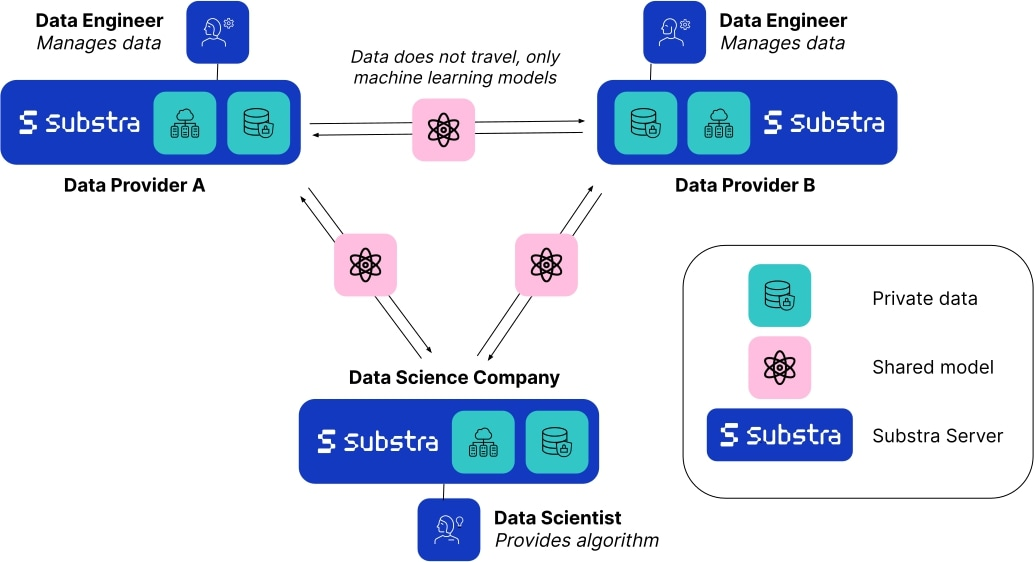

# Data preparation


This section downloads the **MNIST dataset** using the [torchvision library]
(https://pytorch.org/vision/stable/index.html).
It extracts the images from the raw files and locally creates a folder for each
data organization.

Each organization has access to half the training data and half the test data (which
corresponds to **30,000**
images for training and **5,000** for testing each).

The data is then registered into Substra.

In [2]:
from dataset.mnist_dataset import data_registration

dataset_keys, train_datasample_keys, test_datasample_keys = data_registration(data_organizations)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gp/T/tmpm9njl3se/data_mnist/MNIST/raw



# Check in - is everybody with us so far?

### Please do not hestitate if you have any questions

By this point we have completed the preliminary Federated Learning setup in Substra

We have our clients and datasets ready.

# The Machine learning components

**************************************

Here we begin working with familiar data science tools such as PyTorch - although Substra is compatible with any machine learning framework.

In the next section, we will:

- Register a model and its dependencies
- Specify the federated learning strategy
- Specify the training nodes, aggregation node, and the test nodes

And finally run the experiment!



## Model definition


Here we've defined a classic torch CNN model which we will train using Federated Learning.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3 * 3 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, eval=False):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = x.view(-1, 3 * 3 * 64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=not eval)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

## Specifying on how much data to train


We can specify how much data to train on at each round using the ``index_generator`` object.

We specify the batch size and the number of batches called (using ``num_updates``).

In [4]:
from substrafl.index_generator import NpIndexGenerator

# Number of model updates between each FL strategy aggregation.
NUM_UPDATES = 100

# Number of samples per update.
BATCH_SIZE = 32

index_generator = NpIndexGenerator(
    batch_size=BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

## Torch Dataset definition

Here we can do some further data preprocessing before your model interacts with the data.

For example, here we've done some one-hot encoding


In [5]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, datasamples, is_inference: bool):
        self.x = datasamples["images"]
        self.y = datasamples["labels"]
        self.is_inference = is_inference

    def __getitem__(self, idx):
        if self.is_inference:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255
            return x

        else:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255

            y = torch.tensor(self.y[idx]).type(torch.int64)
            y = F.one_hot(y, 10)
            y = y.type(torch.float32)

            return x, y

    def __len__(self):
        return len(self.x)


# SubstraFL algo definition


A [SubstraFL Algo](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms) is the object that gathers all the code that will be run locally in each organization.

This is the only SubstraFL object that is framework specific (here PyTorch specific).



In [6]:
from substrafl.algorithms.pytorch import TorchFedAvgAlgo


class TorchCNN(TorchFedAvgAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=TorchDataset,
            seed=seed,
        )

# Federated Learning strategies

An FL strategy specifies how local updates are aggregated to train a global model from distributed data.

The simplest strategy is the Federated Averaging strategy: do a number of epochs locally then share the weight updates with the aggregation node. The aggregation node then averages all local weight updates (often a weighted average depending on the number of samples of each node, larger data nodes contribute more to the update). These averaged weight updates are then applied on each local model, and we start again the loop.

There exists [other strategies](https://docs.substra.org/en/stable/substrafl_doc/api/strategies.html) implemented in SubstraFL, you can try them out later in this tutorial.



In [7]:
from substrafl.strategies import FedAvg

strategy = FedAvg(algo=TorchCNN())

Metrics definition
==================

As the models will be evaluated throughout the course of the experiment, we also need to add a metric function before we launch our computation

To add a metric, you simply need to define a function that computes and returns a performance from the data!


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np


def accuracy(datasamples, predictions_path):
    y_true = datasamples["labels"]
    y_pred = np.load(predictions_path)

    return accuracy_score(y_true, np.argmax(y_pred, axis=1))


def roc_auc(datasamples, predictions_path):
    y_true = datasamples["labels"]
    y_pred = np.load(predictions_path)

    n_class = np.max(y_true) + 1
    y_true_one_hot = np.eye(n_class)[y_true]

    return roc_auc_score(y_true_one_hot, y_pred)

Where to train where to aggregate
=================================

Where will we train our models?

Where will the training weights be aggregateed?

In SubstraFL, you simply need to define which organizations will act as your training nodes and which will be your aggregation node



In [9]:
from substrafl.nodes import TrainDataNode
from substrafl.nodes import AggregationNode


aggregation_node = AggregationNode(algo_organization_id)

# Create the Train Data Nodes (or training tasks) and save them in a list
train_data_nodes = [
    TrainDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    for org_id in data_organization_ids
]

Where and when to test
======================

With the same logic as the train nodes, we have to specify where we want to test our model.

Remember the evaluation strategy we built earlier? This is where it comes into play



In [10]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy

# Create the Test Data Nodes (or testing tasks) and save them in a list
test_data_nodes = [
    TestDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        test_data_sample_keys=[test_datasample_keys[org_id]],
        metric_functions={"Accuracy": accuracy, "ROC AUC": roc_auc},
    )
    for org_id in data_organization_ids
]


# Test at the end of every round
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, eval_frequency=1)

# Running the experiment

As a last step before launching our experiment, we need to specify the third parties dependencies required to run it.
The `substrafl_doc/api/dependency:Dependency` object is instantiated in order to install the right libraries in
the Python environment of each organization.



In [11]:
from substrafl.dependency import Dependency

dependencies = Dependency(pypi_dependencies=["numpy==1.23.1", "torch==1.11.0", "scikit-learn==1.1.1"])

# Check in - Are we all ready?

We've successful built all the necessary objects to launch our FL experiment.

Lets do a recap of all the objects we created:

- **Clients** to add or retrieve the assets of our experiment, using their keys to
  identify them.
- A **Torch algorithm** to define the training parameters *(optimizer, train
  function, predict function, etc...)*.
- A **Federated Strategy**, to specify how to train the model on
  distributed data.
- **Train and test data nodes** to indicate how we will split the data in different nodes for training and evalation
- An **Evaluation Strategy**, to define where and at which frequency we
  evaluate the model.
- An **Aggregation Node**, to specify the organization on which the aggregation operation
  will be computed.
- The **Number of rounds**, a round being defined by a local training step followed by an aggregation operation.
- An **Experiment folder** to save a summary of the operation made.
- The **Dependencies** to define the libraries on which the experiment needs to run.



# The code cells below are for training and for evaluation during the challenge!

In [12]:
from substrafl.experiment import execute_experiment

# A round is defined by a local training step followed by an aggregation operation
NUM_ROUNDS = 3

compute_plan = execute_experiment(
    client=algo_organization,
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=aggregation_node,
    num_rounds=NUM_ROUNDS,
    experiment_folder="experiment_summaries",
    dependencies=dependencies,
    clean_models=False,
    name="MNIST documentation example",
)

2023-09-12 09:24:30,200 - INFO - Building the compute plan.
2023-09-12 09:24:30,203 - INFO - Registering the functions to Substra.
2023-09-12 09:24:30,453 - INFO - Registering the compute plan to Substra.
2023-09-12 09:24:30,456 - INFO - Experiment summary saved to experiment_summaries/2023_09_12_09_24_30_711b55a0-f465-45c9-bdc6-3fa21e8edf0a.json


Compute plan progress:   0%|          | 0/29 [00:00<?, ?it/s]

/Users/sdiot-girard/prog/substra/substra/sdk/backends/local/backend.py:601: UserWarning: `transient=True` is ignored in local mode
  warnings.warn("`transient=True` is ignored in local mode", stacklevel=1)
2023-09-12 09:25:28,553 - INFO - The compute plan has been registered to Substra, its key is 711b55a0-f465-45c9-bdc6-3fa21e8edf0a.


## Bonus Question: How many tasks does this compute plan have?

# Do this math on the side





This compute plan created is composed of 29 tasks:

* For each local training step, we create 3 tasks per organisation: training + prediction + evaluation -> 3 tasks.
* We are training on 2 data organizations; for each round, we have 3 * 2 local tasks + 1 aggregation task -> 7 tasks.
* We are training for 3 rounds: 3 * 7 -> 21 tasks.
* Before the first local training step, there is an initialization step on each data organization: 21 + 2 -> 23 tasks.
* After the last aggregation step, there are three more tasks: applying the last updates from the aggregator + prediction + evaluation, on both organizations: 23 + 2 * 3 -> 29 tasks

# Explore results




In [13]:
import pandas as pd

performances_df = pd.DataFrame(algo_organization.get_performances(compute_plan.key).dict())
print("\nPerformance Table: \n")
print(performances_df[["worker", "round_idx", "identifier", "performance"]])


Performance Table: 

       worker round_idx identifier  performance
0   MyOrg2MSP         0   Accuracy     0.090200
1   MyOrg2MSP         0    ROC AUC     0.477815
2   MyOrg3MSP         0   Accuracy     0.104000
3   MyOrg3MSP         0    ROC AUC     0.484101
4   MyOrg2MSP         1   Accuracy     0.755200
5   MyOrg2MSP         1    ROC AUC     0.967806
6   MyOrg3MSP         1   Accuracy     0.833600
7   MyOrg3MSP         1    ROC AUC     0.983923
8   MyOrg2MSP         2   Accuracy     0.888600
9   MyOrg2MSP         2    ROC AUC     0.991413
10  MyOrg3MSP         2   Accuracy     0.934000
11  MyOrg3MSP         2    ROC AUC     0.996236
12  MyOrg2MSP         3   Accuracy     0.914200
13  MyOrg2MSP         3    ROC AUC     0.994724
14  MyOrg3MSP         3   Accuracy     0.955800
15  MyOrg3MSP         3    ROC AUC     0.998407


Plot results
============



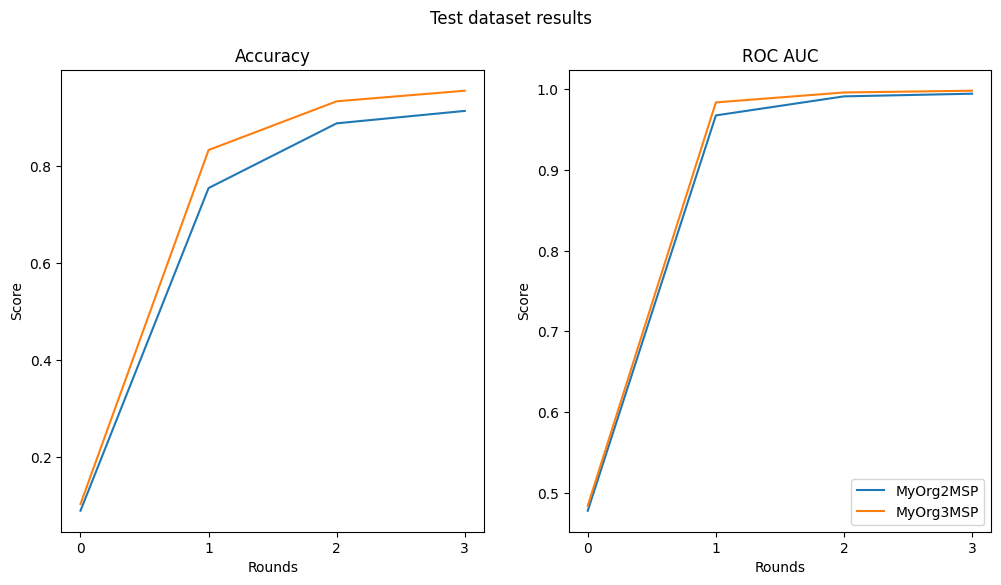

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Test dataset results")

axs[0].set_title("Accuracy")
axs[1].set_title("ROC AUC")

for ax in axs.flat:
    ax.set(xlabel="Rounds", ylabel="Score")


for org_id in data_organization_ids:
    org_df = performances_df[performances_df["worker"] == org_id]
    acc_df = org_df[org_df["identifier"] == "Accuracy"]
    axs[0].plot(acc_df["round_idx"], acc_df["performance"], label=org_id)

    auc_df = org_df[org_df["identifier"] == "ROC AUC"]
    axs[1].plot(auc_df["round_idx"], auc_df["performance"], label=org_id)

plt.legend(loc="lower right")
plt.show()

# Challenge: Improve your performance

### The best model at the end of our session will get a small reward!

**Hints:**

- You can edit the model (but implementing an entirely new model will take time)
- You can edit FL hyperparameters
- You can change the FL strategy

